In [1]:
%load_ext autoreload
%autoreload 2
import numpy
import pandas
import io
import uuid
import psycopg.sql
import pyarrow
import pyarrow.parquet

import jobqueue
from jobqueue.connection_manager import ConnectionManager



import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

import dmp.keras_interface.model_serialization as model_serialization
from dmp.task.experiment.training_experiment.training_epoch import TrainingEpoch

pd.options.display.max_seq_items = None

2024-06-18 16:06:01.769585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 16:06:02.753656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# from enum import Enum, auto

# class ColumnSource(Enum):
#     run_column=auto()
#     run
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()

from dataclasses import dataclass



@dataclass
class Column:
    name : str
    pandas_type : str


In [3]:
'''
parent/root runs:
select
	*
from
	run_data d
where
	command @> '{"experiment":{"type":"LTHExperiment"}}'
limit 10
;
'''

'\nparent/root runs:\nselect\n\t*\nfrom\n\trun_data d\nwhere\n\tcommand @> \'{"experiment":{"type":"LTHExperiment"}}\'\nlimit 10\n;\n'

In [4]:
"""
select
 	command->'experiment'->'dataset'->'name' dataset,
	command->'experiment'->'pruning'->'method'->'pruning_rate' pruning_rate,
	id,
	experiment_id,
	command,
	history
from run
where TRUE
	AND queue >=0
	AND status >= 2
	AND command @> '{"experiment":{
		"type":"IterativePruningExperiment",
		"pruning":{
			"method":{
				"type":"MagnitudePruner"
				}
		}}}'::jsonb
LIMIT 100;
"""

'\nSELECT\n\tdataset,\n\tmodel,\n\texperiment_id,\n\tparent,\n\tid,\n\tpruning_rate\nFROM\n(\n\tSELECT\n\t\th.experiment_id,\n\t\ts.parent,\n\t\ts.id,\n\t\t(d.command->\'experiment\'->\'dataset\'->>\'name\') dataset,\n\t\t(d.command->\'experiment\'->\'model\'->>\'type\') model,\n\t  \t(d.command->\'experiment\'->\'pruning\'->\'method\'->>\'pruning_rate\')::float pruning_rate\n\tFROM\n\t\trun_data d,\n\t\trun_status s,\n\t\thistory h\n\tWHERE TRUE\n\t\tAND s.id = d.id\n\t\tAND h.id = d.id\n\t\tAND d.command @> \'{"experiment":{"type":"IterativePruningExperiment"}}\'::jsonb\n) x\nWHERE TRUE\n\tAND pruning_rate < .5\nORDER BY dataset, model, pruning_rate, experiment_id, parent\n;\n'

In [2]:
def flatten_json(json_obj, parent_key="", separator="_"):
    flattened = {}
    for key, value in json_obj.items():
        new_key = f"{parent_key}{separator}{key}" if parent_key else key
        if isinstance(value, dict):
            flattened.update(flatten_json(value, new_key, separator=separator))
        else:
            flattened[new_key] = value
    return flattened


# AND id IN ('65ef3809-d900-4f86-9591-ff434351b1bc', 'b67d2005-70dc-46e8-969f-3021234e4908')

experiment_id = 0
run_command = {}
credentials = jobqueue.load_credentials("dmp")
dataframes = []
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL(
            """
SELECT
    id,
	experiment_id,
	command,
	history
FROM
    run r
WHERE TRUE
    AND id IN ('95475c6f-2cdd-4d0e-96b7-147ead863143', 'dec62d55-92e2-45a1-939b-321dfc7617a5')
;
"""
        )

        cursor.execute(query, binary=True)


        for row in cursor.fetchall():
            run_id = row[0]
            experiment_id = row[1]

            with io.BytesIO(row[3]) as buffer:
                history = pyarrow.parquet.read_table(
                    pyarrow.PythonFile(buffer, mode="r")
                ).to_pandas()

            run_command = row[2]
            from dmp.marshaling import marshal

            run = marshal.demarshal(run_command)

            experiment_data = {
                "run_id": [run_id],
                "experiment_id":[experiment_id],
            }

            flat = flatten_json(run_command)
            for k, v in flat.items():
                if isinstance(v, list):
                    continue
                experiment_data[k] = [v]
                # history[k] = v

            experiment_df = pd.DataFrame(experiment_data)
            history = history.join(experiment_df, how='cross')
            dataframes.append(history)

history = pd.concat(dataframes, ignore_index=True, axis=0)

history.sort_values(
    ["experiment_id", "run_id", "fit_number", "fit_epoch", "epoch"], inplace=True
)

# history.describe()
sorted(history["run_id"].unique())

NameError: name 'jobqueue' is not defined

In [1]:
experiment = run.experiment
dataset, metrics, loss_metric = experiment._load_and_prepare_dataset()
network = experiment._make_network(experiment.model)
keras_model = experiment
network.summary()

NameError: name 'run' is not defined

In [7]:
print(network.structure.summary())

0: [] -> (<class 'dmp.layer.input.Input'>: 0, (32, 32, 3), "dmp_69") -> [1]
1: [0] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 2352, (16, 16, 16), 7x7, s: 2x2, -b, linear, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [2]
2: [1] -> (<class 'dmp.layer.batch_normalization.BatchNormalization'>: 32, (16, 16, 16), ) -> [3]
3: [2] -> (<class 'dmp.layer.op_layer.OpLayer'>: 0, (16, 16, 16), ) -> [4, 9]
4: [3] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 2304, (16, 16, 16), 3x3, s: 1x1, -b, linear, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [5]
5: [4] -> (<class 'dmp.layer.batch_normalization.BatchNormalization'>: 32, (16, 16, 16), ) -> [6]
6: [5] -> (<class 'dmp.layer.op_layer.OpLayer'>: 0, (16, 16, 16), ) -> [7]
7: [6] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 2304, (16, 16, 16), 3x3, s: 1x1, -b, linear, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [8]
8: [7] -> (<class 'dmp.layer.batch_normalization.BatchNormalization'>: 32, (16, 16, 16), ) -> [9]
9: [8, 3] -> (<

In [8]:
print(history.columns)

Index(['epoch', 'trained_loss', 'trainms_ms', 'test_accuracy', 'trained_ms',
       'trained_accuracy', 'validation_accuracy', 'seed_number', 'retained',
       'validation_loss', 'epoch_startms_ms', 'fit_epoch', 'train_accuracy',
       'free_parameter_count', 'fit_number', 'test_loss',
       'masked_parameter_count', 'train_loss', 'test_ms',
       'test_kullback_leibler_divergence_extended',
       'train_kullback_leibler_divergence_extended',
       'trained_cosine_similarity_extended',
       'trained_categorical_hinge_extended',
       'train_cosine_similarity_extended',
       'validation_cosine_similarity_extended',
       'validation_categorical_hinge_extended',
       'train_categorical_hinge_extended', 'test_categorical_hinge_extended',
       'test_cosine_similarity_extended',
       'validation_kullback_leibler_divergence_extended',
       'trained_kullback_leibler_divergence_extended', 'run_id',
       'experiment_id', 'type', 'config_data_run_id_type',
       'config_da

In [9]:
print((history['epoch'] - history['fit_epoch']).to_string())

0        0
1        0
2        0
3        0
4        3
5        3
6        3
7        3
8        3
9        3
10       3
11       3
12       3
13       3
14       3
15       3
16       3
17       3
18       3
19       3
20       3
21       3
22       3
23       3
24       3
25       3
26       3
27       3
28       3
29       3
30       3
31       3
32       3
33       3
34       3
35       3
36       3
37       3
38       3
39       3
40       3
41       3
42       3
43       3
44       3
45       3
46       3
47       3
48       3
49       3
50       3
51       3
52       3
53       3
54       3
55       3
56       3
57       5
58       5
59       5
60       5
61       5
62       5
63       5
64       5
65       5
66       5
67       5
68       5
69       5
70       5
71       5
72       5
73       5
74       5
75       5
76       5
77       5
78       5
79       5
80       5
81       5
82       5
83       5
84       5
85       5
86       5
87       5
88       5
89       5
90       5

In [10]:
history['experiment_pruning_method_pruning_rate'].loc[0]

0.5208259338240001

In [11]:
from pprint import pprint
pprint(run_command)

{'config': {'data': {'context': {'cpus': [18,
                                          19,
                                          20,
                                          21,
                                          22,
                                          23,
                                          24,
                                          25,
                                          26,
                                          27,
                                          28,
                                          29,
                                          30,
                                          31,
                                          32,
                                          33,
                                          34,
                                          35],
                                 'gpu_memory': 0,
                                 'gpus': [],
                                 'nodes': [1],
                             

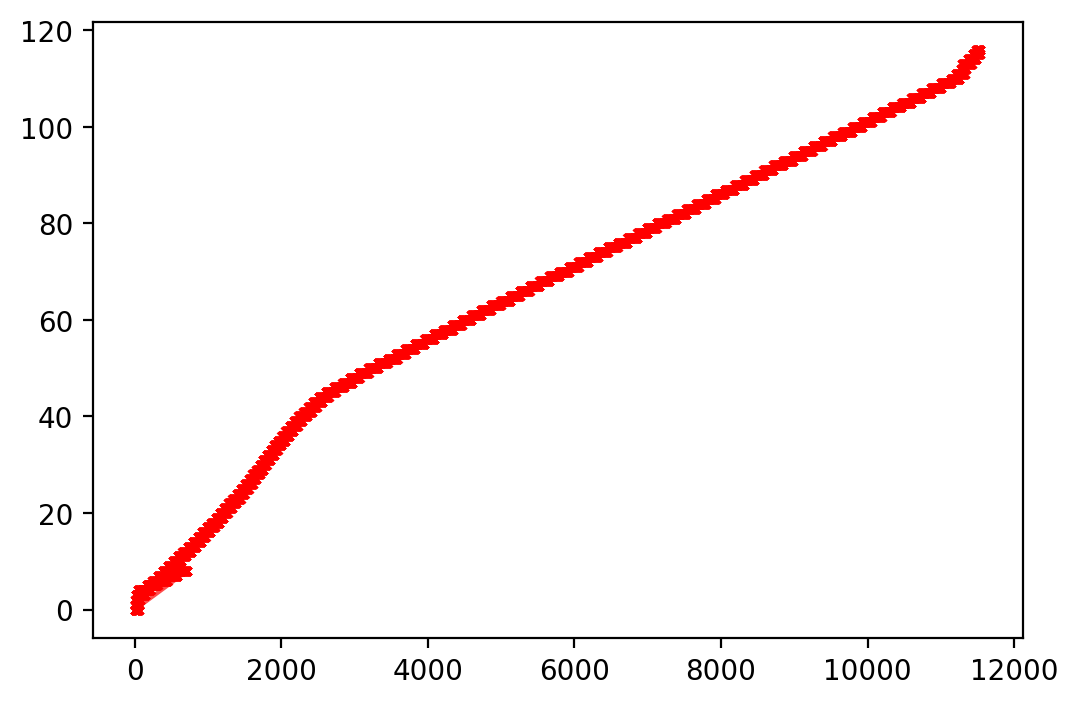

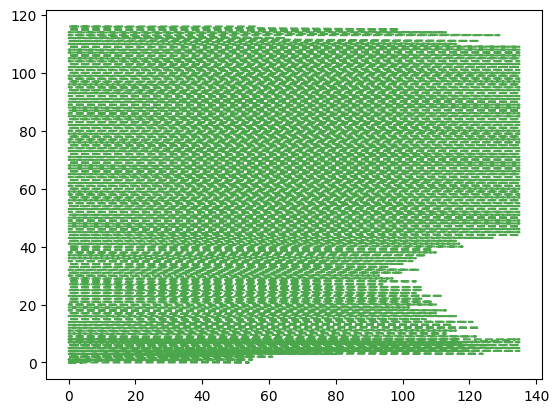

In [52]:
fig = plt.figure(dpi=200, figsize=(6,4))


# plt.semilogy(history['epoch'], history['test_loss'], '-og', markersize=3.0, alpha=.7)
plt.plot(history['epoch'], history['fit_number'], '-xr', markersize=3.0, alpha=.7)
plt.show()
plt.plot(history['fit_epoch'], history['fit_number'], '--g', markersize=3.0, alpha=.7)


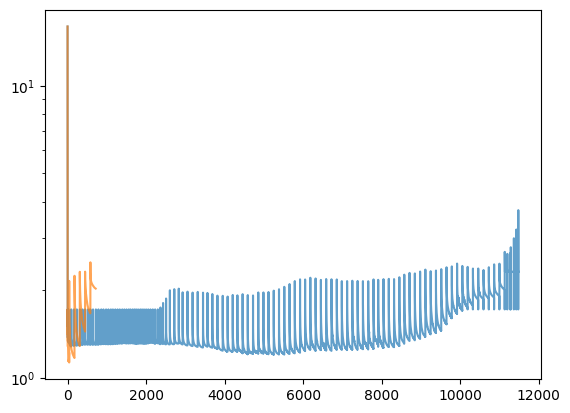

In [53]:
retained = history.loc[history["retained"] == True]
for run_id, run in retained.groupby("run_id"):
    plt.semilogy(run["epoch"], run["test_loss"], "-", markersize=3.0, alpha=0.7)

In [54]:
np.set_printoptions(
    edgeitems=3,
    infstr="inf",
    linewidth=75,
    nanstr="nan",
    precision=8,
    suppress=False,
    threshold=10000,
    formatter=None,
)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

history[
    [
        "epoch",
        "fit_number",
        "fit_epoch",
        "retained",
        "validation_loss",
        "test_loss",
        "masked_parameter_count",
    ]
].head(100)

,epoch,fit_number,fit_epoch,retained,validation_loss,test_loss,masked_parameter_count
14437,0,0,0,True,15.798825,15.931815,0
14438,1,0,1,True,1.713026,1.711687,0
14439,2,0,2,True,1.624588,1.625791,0
14440,3,0,3,True,1.398714,1.407740,0
14441,4,0,4,True,1.392541,1.409716,0
14442,4,1,0,True,1.713026,1.711687,141756
14443,5,1,1,True,1.396127,1.417078,141756
14444,6,1,2,True,1.312124,1.329464,141756
14445,7,1,3,False,1.337291,1.347811,141756
14446,8,1,4,False,1.332270,1.330718,141756


In [14]:
history["masked_parameter_count"]

0           0
1           0
2           0
3           0
4      141756
        ...  
856    271419
857    271419
858    271419
859    271419
860    271419
Name: masked_parameter_count, Length: 861, dtype: int32

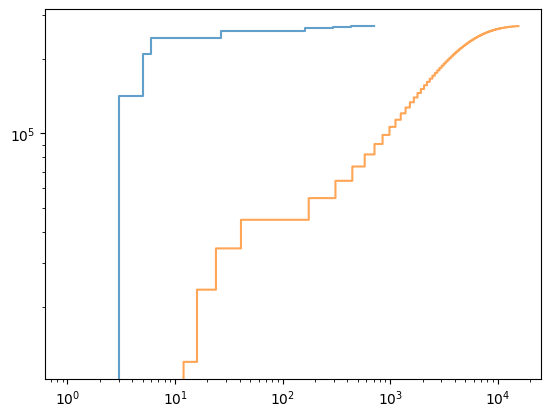

In [46]:
for run_id, run in retained.groupby("run_id"):
    plt.loglog(
        run["epoch"], run["masked_parameter_count"], "-", markersize=3.0, alpha=0.7
    )

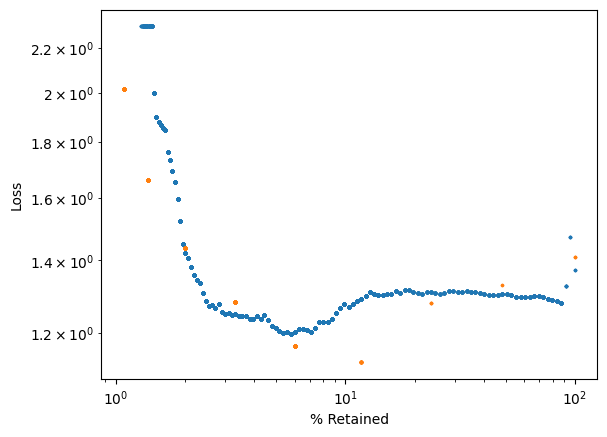

In [58]:
for run_id, run in history.groupby("run_id"):
    retained = run.loc[run["retained"] == True]
    trained = retained.loc[
        retained.groupby(["fit_number"])["epoch"].transform("idxmax")
    ]

    plt.loglog(
        100
        * (1 - (trained["masked_parameter_count"]) / trained["free_parameter_count"]),
        trained["test_loss"],
        ".",
        markersize=3.0,
        alpha=0.7,
    )
    plt.xlabel("% Retained")
    plt.ylabel("Loss")

    # plt.show()
    # plt.semilogx(
    #     100 * (1 - (trained["masked_parameter_count"]) / trained["free_parameter_count"]),
    #     100 * (1 - trained["test_accuracy"]),
    #     ".g",
    #     markersize=3.0,
    #     alpha=0.7,
    # )
    # plt.xlabel("% Retained")
    # plt.ylabel("% Error")
    # plt.semilogy(retained['epoch'], retained['trained_loss'], '--g', markersize=3.0, alpha=.7)

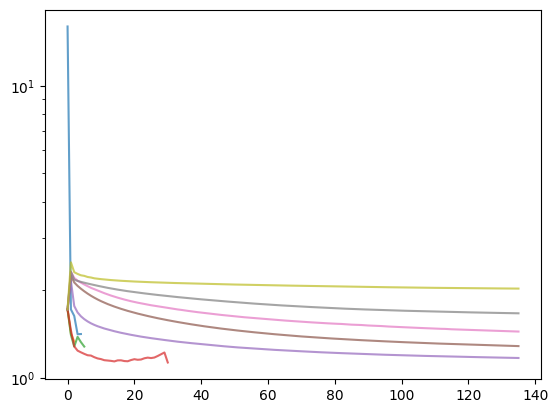

In [59]:

x = retained.loc[retained["fit_number"] < 10]
for fit_number, fit in x.groupby(["fit_number"]):
    plt.semilogy(
        fit["fit_epoch"],
        fit["test_loss"],
        "-",
        markersize=3.0,
        alpha=0.7,
    )

# plt.semilogy(retained['fit_epoch'], retained['test_loss'], '-xr', markersize=3.0, alpha=.7)

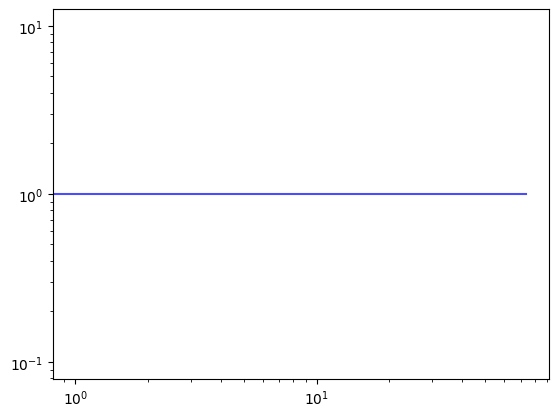

In [25]:
plt.loglog(
    retained["epoch"],
    (retained["free_parameter_count"] - retained["masked_parameter_count"]) / retained["free_parameter_count"],
    "-b",
    markersize=3.0,
    alpha=0.7,
)

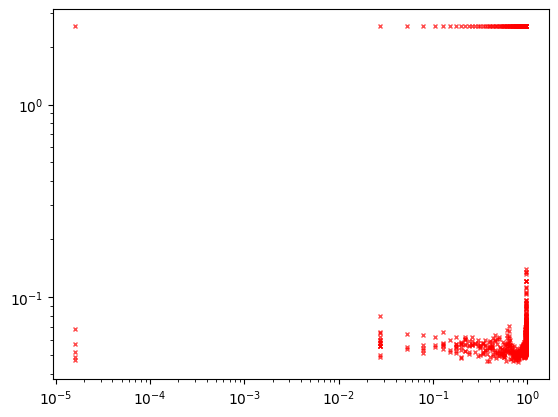

In [17]:
retained = history.loc[history["retained"] == True]
plt.loglog((1 + retained['masked_parameter_count']) / retained['free_parameter_count'], retained['test_loss'], 'xr', markersize=3.0, alpha=.7)

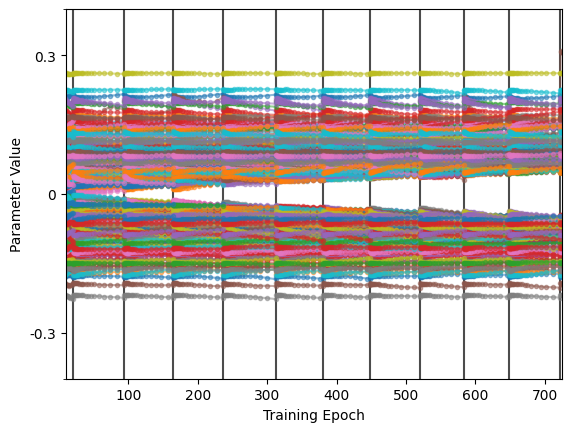

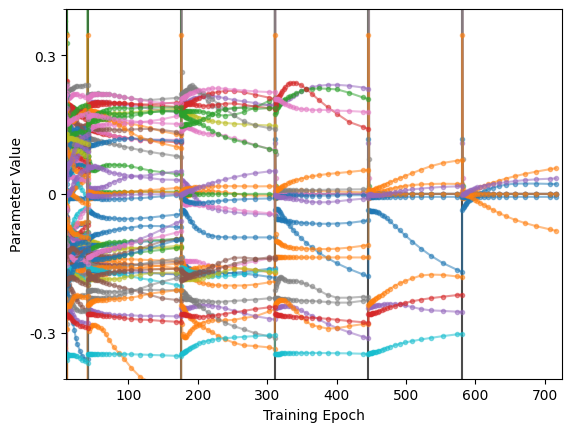

In [106]:
import h5py as h5
import hdf5plugin


def extract_trajectories(parameter_dataset, parameter_indicies, epochs):
    parameter_values = parameter_dataset[parameter_indicies, :]

    trajectories = np.ndarray(shape=(len(parameter_indicies), len(epochs)))
    for i, (epoch, sequence_number) in enumerate(epochs):
        parameters_at_epoch = parameter_values[:, sequence_number]
        trajectories[:, i] = parameters_at_epoch

    return trajectories


for run_id, run in history.groupby("run_id"):
    retained = run.loc[run["retained"] == True]
    # trained = retained.loc[
    #     retained.groupby(["fit_number"])["epoch"].transform("idxmax")
    # ]

    # scp eagle:/projects/modularai/dmp/dmp/model_data/c1a3792d-c30d-4b55-9ca4-d1bbcc59518c.h5 .
    dmp_path = "/home/ctripp/dmp/dmp/"
    model_data_dir = os.path.join(dmp_path, "model_data")
    checkpoint_path = os.path.join(model_data_dir, f"{run_id}.h5")
    with h5.File(checkpoint_path, "r") as h5_file:
        (
            epoch_dataset,
            parameter_dataset,
            optimizer_datasets,
        ) = model_serialization.get_datasets_from_model_file(h5_file, None)

        global_epoch = epoch_dataset[0, :]
        fit_number = epoch_dataset[1, :]
        fit_epoch = epoch_dataset[2, :]
        epoch_marker = epoch_dataset[3, :]

        epochs = []
        for i in range(epoch_dataset.shape[1]):
            epoch = TrainingEpoch(
                global_epoch[i], fit_number[i], fit_epoch[i], epoch_marker[i]
            )

            if retained.loc[
                (retained["epoch"] == epoch.epoch)
                & (retained["fit_number"] == epoch.fit_number)
                & (retained["fit_epoch"] == epoch.fit_epoch)
            ].empty:
                continue
            epochs.append(
                (
                    epoch,
                    i,
                )
            )
        epochs.sort()

        # initial_epochs = [tup for tup in epochs if tup[0].fit_epoch == 0]
        # final_epochs = [tup for tup in epochs if tup[0].marker != 0]

        epoch_ranges = []
        fit_number = None
        for epoch, sequence_number in epochs:
            if (
                len(epoch_ranges) == 0
                or epoch_ranges[-1][-1][0].fit_number != epoch.fit_number
            ):
                plt.axvline(x=epoch.epoch, color="k", alpha=0.7)
                epoch_ranges.append([])
            epoch_ranges[-1].append((epoch, sequence_number))

        # samples = []
        # for epoch_range in epoch_ranges:
        #     trajectories
        # parameter_indicies = list(range(40))

        num_samples = 1000
        num_samples = min(num_samples, parameter_dataset.shape[0])
        parameter_indicies = np.random.choice(
            parameter_dataset.shape[0], replace=False, size=num_samples
        )
        parameter_indicies = list(np.sort(parameter_indicies))

        trajectories = extract_trajectories(
            parameter_dataset, parameter_indicies, epochs
        )

        for i in range(trajectories.shape[0]):
            plt.plot(
                [epoch.epoch for epoch, sequence_number in epochs],
                trajectories[i, :],
                ".-",
                alpha=0.5,
            )

        plt.yscale('symlog')
        # plt.xscale('log')
        plt.xlim(10,725)
        plt.xlabel("Training Epoch")
        plt.ylabel("Parameter Value")
        plt.ylim(-.4,.4)
        plt.yticks([-0.3, 0, 0.3], ['-0.3', '0', '0.3'])

        plt.show()
        # for epoch, sequence_number in epochs:
        # if epoch.fit_epoch == 0:
        #     plt.axvline(x=epoch.epoch, color="r", alpha=0.5)

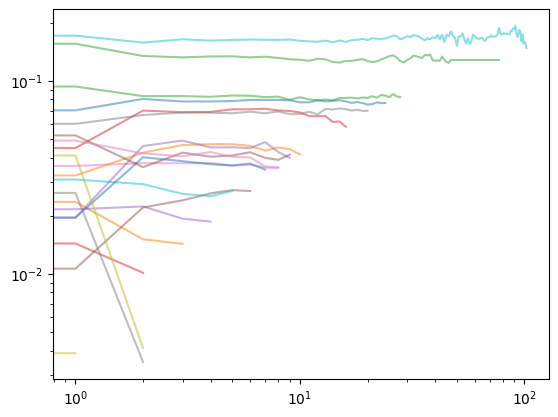

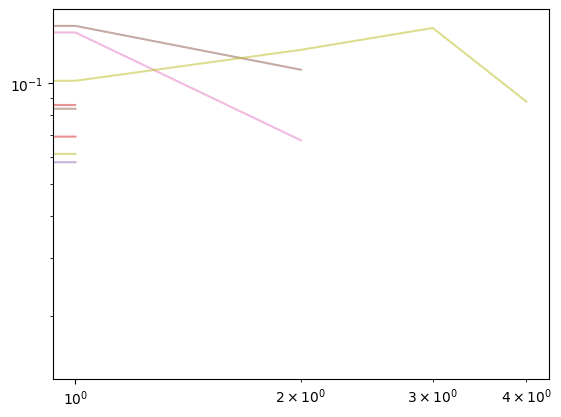

In [61]:
import h5py as h5
import hdf5plugin


def extract_trajectories(parameter_dataset, parameter_indicies, epochs):
    parameter_values = parameter_dataset[parameter_indicies, :]

    trajectories = np.ndarray(shape=(len(parameter_indicies), len(epochs)))
    for i, (epoch, sequence_number) in enumerate(epochs):
        parameters_at_epoch = parameter_values[:, sequence_number]
        trajectories[:, i] = parameters_at_epoch

    return trajectories


for run_id, run in history.groupby("run_id"):
    retained = run.loc[run["retained"] == True]
    # trained = retained.loc[
    #     retained.groupby(["fit_number"])["epoch"].transform("idxmax")
    # ]

    # scp eagle:/projects/modularai/dmp/dmp/model_data/c1a3792d-c30d-4b55-9ca4-d1bbcc59518c.h5 .
    dmp_path = "/home/ctripp/dmp/dmp/"
    model_data_dir = os.path.join(dmp_path, "model_data")
    checkpoint_path = os.path.join(model_data_dir, f"{run_id}.h5")
    with h5.File(checkpoint_path, "r") as h5_file:
        (
            epoch_dataset,
            parameter_dataset,
            optimizer_datasets,
        ) = model_serialization.get_datasets_from_model_file(h5_file, None)

        global_epoch = epoch_dataset[0, :]
        fit_number = epoch_dataset[1, :]
        fit_epoch = epoch_dataset[2, :]
        epoch_marker = epoch_dataset[3, :]

        epochs = []
        for i in range(epoch_dataset.shape[1]):
            epoch = TrainingEpoch(
                global_epoch[i], fit_number[i], fit_epoch[i], epoch_marker[i]
            )

            if retained.loc[
                (retained["epoch"] == epoch.epoch)
                & (retained["fit_number"] == epoch.fit_number)
                & (retained["fit_epoch"] == epoch.fit_epoch)
            ].empty:
                continue
            epochs.append(
                (
                    epoch,
                    i,
                )
            )
        epochs.sort()

        initial_epochs = [tup for tup in epochs if tup[0].fit_epoch == 0]
        final_epochs = [tup for tup in epochs if tup[0].marker != 0]

        # parameter_indicies = list(range(40))
        num_samples = 20
        num_samples = min(num_samples, parameter_dataset.shape[0])
        parameter_indicies = np.random.choice(
            parameter_dataset.shape[0], replace=False, size=num_samples
        )
        parameter_indicies = list(np.sort(parameter_indicies))

        initial_trajectories = extract_trajectories(
            parameter_dataset, parameter_indicies, initial_epochs
        )
        final_trajectories = extract_trajectories(
            parameter_dataset, parameter_indicies, final_epochs
        )

        # global_epoch = np.fromiter(
        #     (epoch.epoch for epoch, sequence_number in epochs), dtype=int
        # )
        # for i in range(trajectories.shape[0]):
        #     plt.loglog(global_epoch, trajectories[i, :], "-", alpha=0.5)
        # for i in range(initial_trajectories.shape[0]):
        #     plt.semilogy(
        #         list(range(len(epochs))), initial_trajectories[i, :], "-", alpha=0.5
        #     )

        for i in range(final_trajectories.shape[0]):
            plt.loglog(
                list(range(len(final_epochs))),
                np.abs(final_trajectories[i, :]),
                "-",
                alpha=0.5,
            )

        plt.show()
        # for epoch, sequence_number in epochs:
        # if epoch.fit_epoch == 0:
        #     plt.axvline(x=epoch.epoch, color="r", alpha=0.5)

In [19]:
print(epoch_dataset[:,:])

RuntimeError: Unable to synchronously get dataspace (invalid dataset identifier)

In [ ]:
with h5.File(checkpoint_path, "r") as h5_file:
    (
        epoch_dataset,
        parameter_dataset,
        optimizer_datasets,
    ) = model_serialization.get_datasets_from_model_file(h5_file, None)

    epoch = TrainingEpoch(epoch_dataset[0,0],
                          epoch_dataset[1,0],
                          epoch_dataset[2,0],
                          epoch_dataset[3,0],)

model = experiment._make_model_from_network(network, metrics)
model_serialization.load_parameters(
        model.network.structure,
        model.keras_network.layer_to_keras_map,
        None,
        checkpoint_path,
        epoch,
        load_mask=True,
    )

0: [] -> (<class 'dmp.layer.input.Input'>: 0, (28, 28, 1), "dmp_8") -> [1]
1: [0] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 156, (28, 28, 6), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [2]
2: [1] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (14, 14, 6), s: 2x2) -> [3]
3: [2] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 2416, (10, 10, 16), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [4]
4: [3] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (5, 5, 16), s: 2x2) -> [5]
5: [4] -> (<class 'dmp.layer.flatten.Flatten'>: 0, (400,), ) -> [6]
6: [5] -> (<class 'dmp.layer.dense.Dense'>: 48120, (120,), x120, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [7]
7: [6] -> (<class 'dmp.layer.dense.Dense'>: 10164, (84,), x84, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [8]
8: [7] -> (<class 'dmp.layer.dense.Dense'>: 850, (10,), x10, softmax, kc:"<class 'NoneType'>: None") -> []
0: [] -> (<class 'dmp.layer.input.Input'>: 0,

TrainingEpoch(epoch=8, fit_number=1, fit_epoch=0, marker=0, sequence_number=0)

In [ ]:
for layer in model.network.structure.layers:
    print(layer)

In [ ]:
model.keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dmp_8 (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 dmp_7 (Conv2D)              (None, 28, 28, 6)         156       
                                                                 
 dmp_6 (MaxPooling2D)        (None, 14, 14, 6)         0         
                                                                 
 dmp_5 (Conv2D)              (None, 10, 10, 16)        2416      
                                                                 
 dmp_4 (MaxPooling2D)        (None, 5, 5, 16)          0         
                                                                 
 dmp_3 (Flatten)             (None, 400)               0         
                                                                 
 dmp_2 (Dense)               (None, 120)               48120 

 dmp_1 (Dense)               (None, 84)                10164     
                                                                 
 dmp_0 (Dense)               (None, 10)                850       
                                                                 
Total params: 61706 (241.04 KB)
Trainable params: 61706 (241.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow.keras as keras
for layer in model.network.structure.layers:
    layer_info = model.keras_network.layer_to_keras_map.get(layer, None)
    if layer_info is None:
        continue

    keras_layer = layer_info.keras_layer
    if keras_layer is None or not isinstance(keras_layer, keras.layers.Layer):
        continue

    for i, variable in enumerate(keras_layer.variables):  # type: ignore
        print(f'layer:{layer} variable {i} with name {variable.name} and shape {variable.shape}')

layer:<dmp.layer.dense.Dense object at 0x7fe64c287fa0> variable 0 with name dmp_0/kernel:0 and shape (84, 10)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287fa0> variable 1 with name dmp_0/bias:0 and shape (10,)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287eb0> variable 0 with name dmp_1/kernel:0 and shape (120, 84)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287eb0> variable 1 with name dmp_1/bias:0 and shape (84,)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287f10> variable 0 with name dmp_2/kernel:0 and shape (400, 120)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287f10> variable 1 with name dmp_2/bias:0 and shape (120,)
layer:<dmp.layer.dense_conv.DenseConv object at 0x7fe64c287760> variable 0 with name dmp_5/kernel:0 and shape (5, 5, 6, 16)
layer:<dmp.layer.dense_conv.DenseConv object at 0x7fe64c287760> variable 1 with name dmp_5/bias:0 and shape (16,)
layer:<dmp.layer.dense_conv.DenseConv object at 0x7fe64c287d60> variable 0 with name dmp_7/kernel:0 and shape (5,

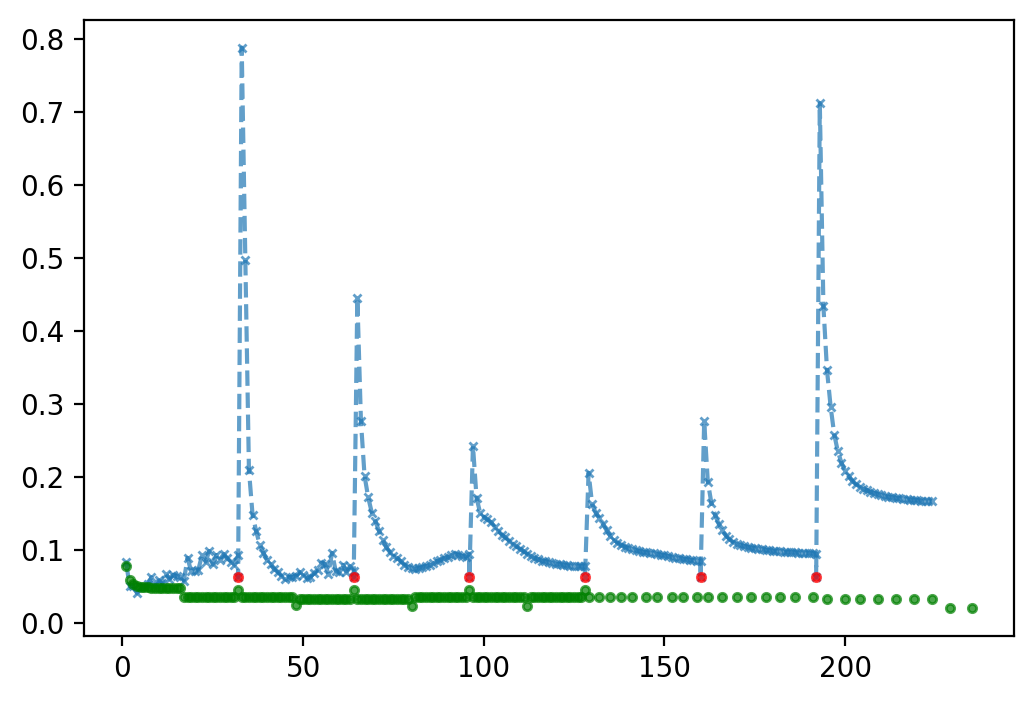

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['test_loss'], '--x', markersize=3.0, alpha=.7)
new_iterations = history[history['model_epoch'] == 0]
plt.plot(by_epoch['epoch'], by_epoch['test_loss_cmin_quantile_50'], 'og', markersize=3.0, alpha=.7)

plt.plot(new_iterations['epoch'], new_iterations['test_loss'], 'or', markersize=3.0, alpha=.7)


In [ ]:
history.columns

Index(['test_loss', 'trained_categorical_crossentropy', 'trained_accuracy',
       'train_categorical_crossentropy', 'free_parameter_count',
       'train_accuracy', 'retained', 'validation_categorical_crossentropy',
       'masked_parameter_count', 'validation_accuracy', 'trainms_ms',
       'trained_ms', 'train_loss', 'test_ms', 'model_epoch', 'epoch',
       'validation_loss', 'seed_number', 'test_accuracy', 'model_number',
       'test_categorical_crossentropy', 'trained_loss', 'epoch_startms_ms'],
      dtype='object')

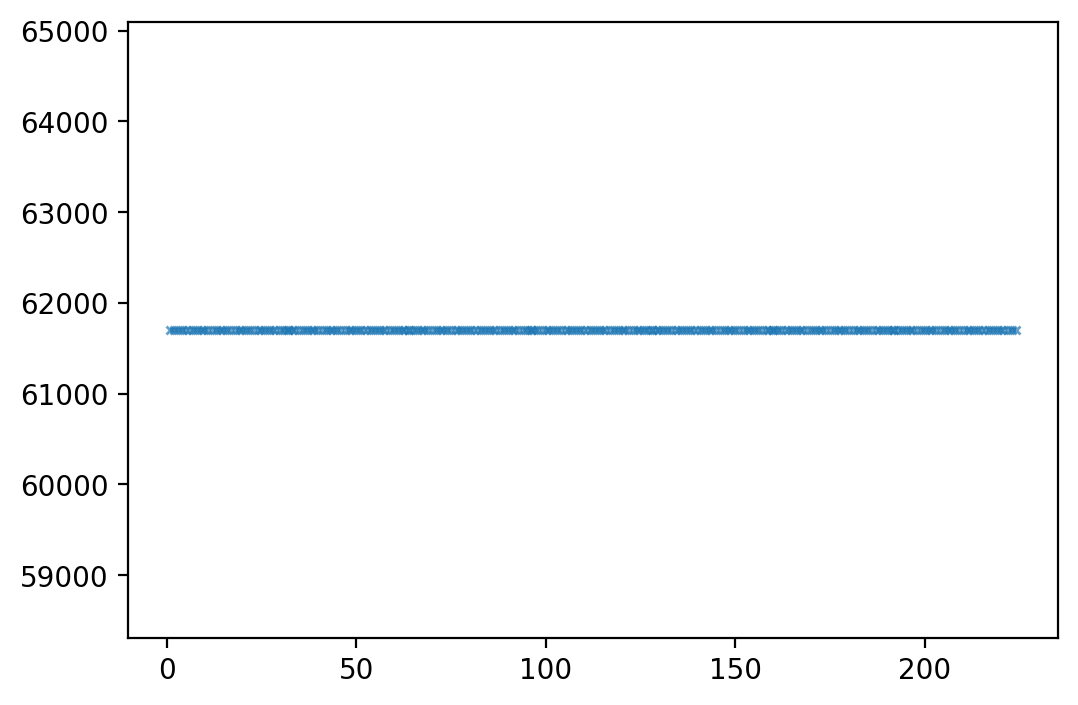

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['free_parameter_count'], '--x', markersize=3.0, alpha=.7)


In [ ]:

credentials = jobqueue.load_credentials('dmp')
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL("""
SELECT
    by_epoch
FROM
    experiment2 e
WHERE TRUE
    AND e.experiment_id = 'b0d415cf-f228-c439-0480-3337c543c2e4'
LIMIT 1;
""")

        cursor.execute(query, binary=True)
        row = cursor.fetchone()
        with io.BytesIO(row[0]) as buffer:
            by_epoch = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()


by_epoch.describe()
by_epoch

,epoch,count,model_epoch_quantile_0,model_epoch_quantile_25,model_epoch_quantile_50,model_epoch_quantile_75,model_epoch_quantile_100,trained_categorical_crossentropy_quantile_0,trained_categorical_crossentropy_quantile_25,trained_categorical_crossentropy_quantile_50,...,test_accuracy_cmax_quantile_0,test_accuracy_cmax_quantile_25,test_accuracy_cmax_quantile_50,test_accuracy_cmax_quantile_75,test_accuracy_cmax_quantile_100,validation_accuracy_cmax_quantile_0,validation_accuracy_cmax_quantile_25,validation_accuracy_cmax_quantile_50,validation_accuracy_cmax_quantile_75,validation_accuracy_cmax_quantile_100
0,1,8,1.0,1.0,1.0,1.0,1.0,0.060437,0.061399,0.066523,...,0.9734,0.973925,0.97625,0.977575,0.9798,0.974000,0.975571,0.976571,0.977286,0.980571
1,2,8,2.0,2.0,2.0,2.0,2.0,0.039023,0.039946,0.041580,...,0.9762,0.980350,0.98225,0.982875,0.9843,0.980000,0.981071,0.981429,0.982143,0.985143
2,3,8,3.0,3.0,3.0,3.0,3.0,0.028624,0.030501,0.035552,...,0.9810,0.981500,0.98280,0.983900,0.9866,0.980857,0.981643,0.983000,0.984071,0.989429
3,4,8,4.0,4.0,4.0,4.0,4.0,0.019772,0.025258,0.027370,...,0.9812,0.981675,0.98450,0.985625,0.9885,0.980857,0.983214,0.983857,0.986857,0.989429
4,5,8,5.0,5.0,5.0,5.0,5.0,0.017522,0.022112,0.024034,...,0.9816,0.984450,0.98495,0.985650,0.9885,0.980857,0.983929,0.985429,0.987071,0.989429
5,6,8,6.0,6.0,6.0,6.0,6.0,0.016902,0.019114,0.019577,...,0.9819,0.984825,0.98520,0.986550,0.9885,0.984000,0.984786,0.985571,0.987071,0.989429
6,7,8,7.0,7.0,7.0,7.0,7.0,0.014243,0.016146,0.017878,...,0.9851,0.985725,0.98655,0.988050,0.9885,0.984000,0.985143,0.986000,0.987214,0.989429
7,8,8,8.0,8.0,8.0,8.0,8.0,0.010488,0.012256,0.017983,...,0.9851,0.986250,0.98745,0.988500,0.9888,0.984000,0.985143,0.986143,0.987214,0.989714
8,9,8,9.0,9.0,9.0,9.0,9.0,0.010544,0.011973,0.016272,...,0.9851,0.986250,0.98775,0.988500,0.9891,0.984000,0.985143,0.986143,0.987214,0.990000
9,10,8,10.0,10.0,10.0,10.0,10.0,0.008422,0.011188,0.012371,...,0.9859,0.986800,0.98775,0.988500,0.9897,0.984000,0.985143,0.986714,0.988643,0.990000


In [ ]:
df.columns

Index(['experiment_id', 'old_experiment_id', 'experiment_attrs', 'run_id',
       'job_id', 'slurm_job_id', 'run_timestamp', 'seed', 'task_version',
       'num_nodes',
       ...
       'precision', 'worker_id', 'record_model', 'record_times',
       'python_version', 'record_metrics', 'tensorflow_version',
       'tensorflow_strategy', 'record_post_training_metrics',
       'make_batch_optimizer_butter_growth_eagle_gpu_1'],
      dtype='object', length=105)

In [ ]:
df['run_history'].iloc[0]['train_loss']


0      1.247540
1      0.898057
2      0.847315
3      0.850349
4      0.847144
         ...   
145    0.225552
146    0.213775
147    0.213580
148    0.213284
149    0.210847
Name: train_loss, Length: 150, dtype: float32

In [ ]:
run_df = df['run_history'].iloc[0]
run_df['trained_loss'] - run_df['train_loss']

0      0.000000
1     -0.047707
2      0.003034
3      0.000000
4     -0.001494
         ...   
145    0.026551
146   -0.015600
147   -0.015426
148   -0.008199
149    0.011152
Length: 150, dtype: float32